This notebook explores how to calculate the area within the zero isotherm - that is, the area of the Cold Intermediate Layer

In [1]:
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import shapely
from shapely.geometry.polygon import Polygon

%matplotlib inline

# Load data

In [2]:
#coordinates of seal island transect
stations = pd.read_table('sealisland.txt', delimiter=' ')
numstations=stations.shape[0]
# distance along transect in km
distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]

In [3]:
# Read PSY4 data along SealIsland - I already saved in a csv
d = pd.read_csv('SealIsland_2020_global-analysis-forecast-phy-001-024.csv')

In [4]:
# Create arrays
temp = d['Temperature [degrees_C]'].values
depths = d['Depth [m]'].values
size=len(temp)
# Reshape data
numdepths = int(size/numstations)
temp = temp.reshape((numstations, numdepths ))
temp = np.ma.masked_invalid(temp)
depths = depths.reshape((numstations, numdepths))
_, distance = np.meshgrid(depths[0, :], distance)
mask = temp.mask
mask = mask*np.ones(mask.shape)

In [5]:
# Load PSY4 vertical gridspacing and interploate to Seal Island transect.
f = xr.open_dataset('/home/soontiensn/remote2/hank/nrt.cmems-du.eu/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024-statics/GLO-MFC_001_024_coordinates.nc')
e3t = f['e3t']

In [6]:
# Intperoalte e3t to transect
e3t_stations= np.empty((numstations, numdepths))
for i in range(numstations):
    print(i)
    lat=stations.iloc[i]['LAT']
    lon=stations.iloc[i]['LON']
    sid=stations.iloc[i]['STATION']
    estation = e3t.sel(latitude=lat, longitude=lon, method='nearest')
    e3t_stations[i,:] = estation

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [7]:
e3t_stations = np.ma.masked_invalid(e3t_stations)

# Plotting

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


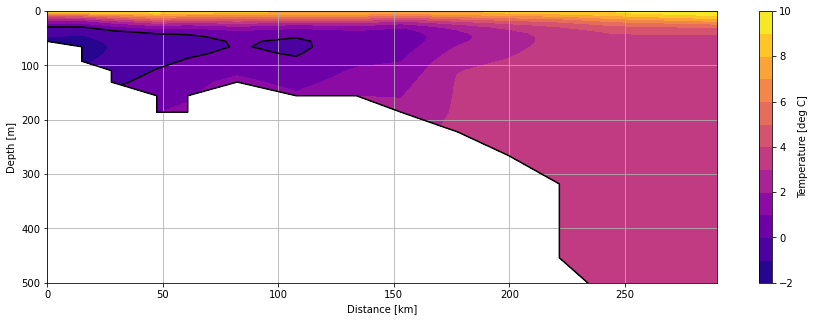

In [8]:
#Quick plot
fig, ax = plt.subplots(1,1,figsize=(15,5))
mesh = ax.contourf(distance, depths, temp, cmap='plasma',levels=np.arange(-2, 11,1))
contour = ax.contour(distance, depths, temp, [0,], colors='k')
cmask = ax.contour(distance, depths, mask, [1,], colors='k')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Temperature [deg C]')
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
ax.grid()

In [9]:
# Idea: mask out data >0
below_zero = np.ma.masked_greater(temp, 0)

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


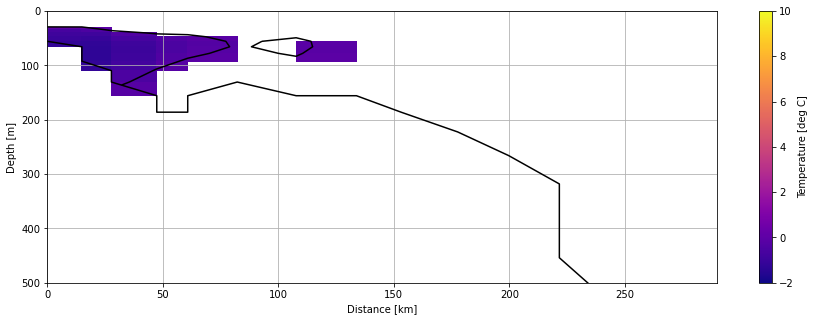

In [10]:
#Plot the masked data
fig, ax = plt.subplots(1,1,figsize=(15,5))
mesh = ax.pcolormesh(distance, depths, below_zero,
                 cmap='plasma',vmin=-2,vmax=10)
contour = ax.contour(distance, depths, temp, [0,], colors='k')
cmask = ax.contour(distance, depths, mask, [1,], colors='k')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Temperature [deg C]')
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
ax.grid()

# Area option 1 (easy)

Hmm, contours are interpolating over the grid...

From here I will add up the area of the cells that aren't masked.

I need an array of diffs. I have the PSY4 vertical grid spacing (e3t). Horizontally, I will take a diff of the stations positions. 

In [11]:
diff_x = np.diff(distance,axis=0)
print(diff_x.shape, e3t_stations.shape)
print(diff_x[:,0])

(13, 50) (14, 50)
[14.96496702 12.77047273 19.63476018 13.4035674  21.43171068 25.48800823
 26.10888263 19.32414717 24.49543048 22.0894874  21.91778875 23.18655791
 45.01707053]


In [12]:
# Calculate area
area = e3t_stations[:-1, :]*diff_x/1000*(1-below_zero.mask[:-1,:])
print(np.nansum(area))

6.005758193345814


# Area option 2 (hard)
This method challenging to reproduce robustly or all possible contour configurations...

Here is my approach
* Firgure out where the zero contour intersects the ground
* Use a combination of the "ground" contours and the zero contours define a polygon
* Calculate area of the polygon

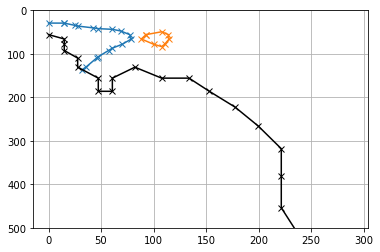

In [13]:
# Plot vertices of the zero contours 
# Note: the objects contour/cmask were defined above with the ax.contour(...) calls
fig,ax = plt.subplots(1,1)
for z in contour.collections:
    v = z.get_paths()
    # Loop through all zero contours
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        ax.plot(x,y,'-x')
ax.set_ylim([500,0])
# Plot vertices of the cmask
for z in cmask.collections:
    v = z.get_paths()
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        ax.plot(x,y,'kx-',)
ax.set_ylim([500,0])
ax.grid()

In this case, the last vertex of the first zero contour intersects the ground contour (by eye).  Is there an algorithm to check that??? Could I check that the last line segment of the zero contour intersects with the appropriate line segment from the ground contour? To consider for later...

* Next step: look up last vertex of first zero contour, then identify all grounded contours to the left - this will give me the bottom of the polygon!

In [14]:
for z in contour.collections:
    v = z.get_paths()
    count=0
    # Plot vertices of the zero contour
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        if count==0:
            intersect_x = x[-1]
            intersect_y = y[-1]
        count+=1

In [15]:
print(intersect_x, intersect_y)

32.08797173785861 136.24881259053967


In [16]:
# Loopt trhough cmask and lists coods with x < intersect_x:
maskx, masky=[],[]
for z in cmask.collections:
    v = z.get_paths()
    for p in v:
        xs = p.vertices[:,0]
        ys = p.vertices[:,1]
        for x,y in zip(xs,ys):
            if  x <= intersect_x:
                maskx.append(x)
                masky.append(y)

(500.0, 0.0)

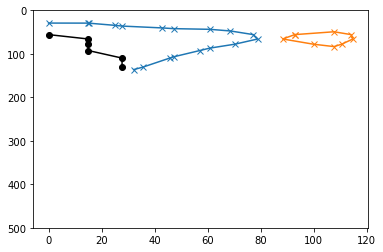

In [17]:
# Plot to visualy check
fig,ax = plt.subplots(1,1)
for z in contour.collections:
    v = z.get_paths()
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        ax.plot(x,y,'-x')
ax.plot(maskx,masky,'-ok')
ax.set_ylim([500,0])

(0.5, 0.0)

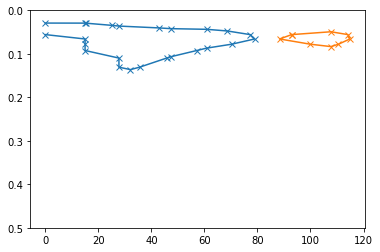

In [18]:
# Now create my polygons - remember to scale y vertices by 1000 to convert from m to km.
# Polygon 1
count=0
polygon1_x=[]
polygon1_y=[]
for z in contour.collections:
    v = z.get_paths()
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        if count==0:
            polygon1_x.extend(x.tolist())
            polygon1_y.extend(y.tolist())
        count+=1
polygon1_x.extend(maskx[:])
polygon1_y.extend(masky[:])
polygon1_y = [y/1000 for y in polygon1_y ]
# Polygon 2
count=0
polygon2_x=[]
polygon2_y=[]
for z in contour.collections:
    v = z.get_paths()
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        if count==1:
            polygon2_x.extend(x)
            polygon2_y.extend(y)
        count+=1
polygon2_y = [y/1000 for y in polygon2_y ]
fig, ax=plt.subplots()
ax.plot(polygon1_x, polygon1_y, 'x-')
ax.plot(polygon2_x, polygon2_y, 'x-')
ax.set_ylim([0.5,0])

In [19]:
print(polygon2_x)
print(polygon2_y)

[92.90269369107, 107.69348623243758, 114.13953829787968, 114.82192146938598, 110.56148110888897, 107.69348623243758, 99.9588811612261, 88.34774383242856, 92.90269369107]
[0.05576428985595703, 0.049233013417482534, 0.05576428985595703, 0.06580726623535156, 0.07785385131835937, 0.08330065079273506, 0.07785385131835937, 0.06580726623535156, 0.055764289855957036]


Interesting! It would be easy to check that contours are closed by looking at the start/end coordinates. That makes it a little bit easier to identify which contours intersect with the ground.

In [20]:
# Creat shapely polygons
poly1 = Polygon((x,y) for x,y in zip(polygon1_x, polygon1_y))
poly2 = Polygon((x,y) for x,y in zip(polygon2_x, polygon2_y))

area = poly1.area + poly2.area
print(area)

4.807365629409965


# Take away
There are significant differences between these two options.

* Option 1 - Calculate area of gridded data < 0 degrees. This is pretty easy to do
  * Area: 6.0 km^2
* Option 2 - Define polygons using the 0 contours and bottom topograghy. This is more challenging to do in an automated/algorithmic way.
  * Area: 4.8 km^2

Moving forward: I think it's best to check how the calculation is done with the observations so that the model data versions are comparable...

In [21]:
# Create arrays
temp = d['Temperature [degrees_C]'].values
depths = d['Depth [m]'].values
size=len(temp)
# Reshape data
numdepths = int(size/numstations)
temp = temp.reshape((numstations, numdepths ))
temp = np.ma.masked_invalid(temp)
depths = depths.reshape((numstations, numdepths))
mask = temp.mask
mask = mask*np.ones(mask.shape)

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


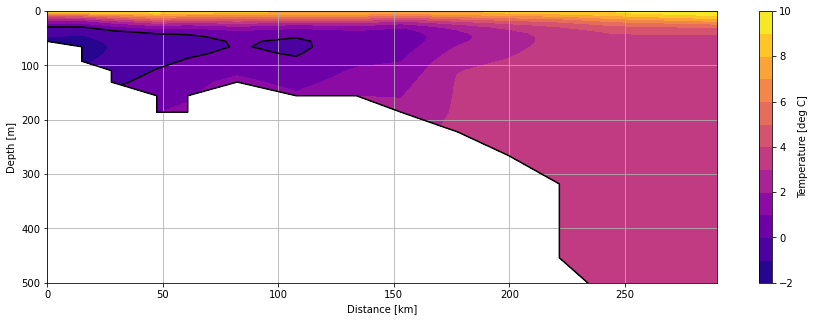

In [22]:
#Quick plot
fig, ax = plt.subplots(1,1,figsize=(15,5))
mesh = ax.contourf(distance, depths, temp, cmap='plasma',levels=np.arange(-2, 11,1))
contour = ax.contour(distance, depths, temp, [0,], colors='k')
cmask = ax.contour(distance, depths, mask, [1,], colors='k')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('Temperature [deg C]')
ax.set_ylim([500,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [km]')
ax.grid()

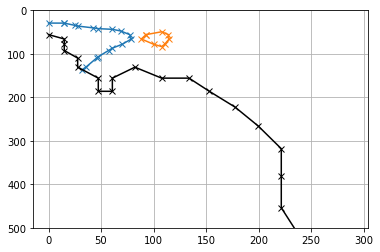

In [23]:
# Plot vertices of the zero contours 
# Note: the objects contour/cmask were defined above with the ax.contour(...) calls
fig,ax = plt.subplots(1,1)
for z in contour.collections:
    v = z.get_paths()
    # Loop through all zero contours
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        ax.plot(x,y,'-x')
ax.set_ylim([500,0])
# Plot vertices of the cmask
for z in cmask.collections:
    v = z.get_paths()
    for p in v:
        x = p.vertices[:,0]
        y = p.vertices[:,1]
        ax.plot(x,y,'kx-',)
ax.set_ylim([500,0])
ax.grid()